In [37]:
import numpy as np
import EFIE as solve
light_speed, mu0, eps0 = 299792458., 4*np.pi*1e-7, 8.854e-12

frequency = 1e6 * 146
omega, wavelength = 2 * np.pi * frequency, light_speed / frequency
incident_field, radius = 10, 3.175e-3
delta_r = wavelength / 5e2

class yagi:
    def __init__(self, position, angle, length, source_position, radius):
        self.position = position
        self.angle = angle
        self.length = length
        self.source_position = source_position
        self.radius = radius

structure_type = 'yagi-uda'
pos = np.array([[0.0, 0.0, 0.0]])
angle = np.array([[0.0, 0.0]])
lengths = np.array([wavelength/2])
source_position = np.array([[0.0, 0.0, 0.0, incident_field]])
radii = np.array([radius])
test = yagi(pos, angle, lengths, source_position, radii)

In [35]:
basis_functions = 'pulse'
current_pulse, R_pulse = solve.calc_current_amplitudes(structure_type=structure_type, basis_functions=basis_functions, antenna=test, frequency=frequency, delta_r=delta_r)
E_pulse, angles = solve.calc_field_pattern (phi=0, theta=0, basis_functions=basis_functions, current=current_pulse, R=R_pulse, delta_r=delta_r, frequency=frequency)

  0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\lukas\OneDrive\Документы\Method-of-moment-for-antennas\MyMomVenv\Lib\site-packages\scipy\integrate\_quadpack_py.py:1260: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
100%|██████████| 1/1 [00:27<00:00, 27.47s/it]


In [38]:
basis_functions = 'triangle'
current_triangle, R_triangle = solve.calc_current_amplitudes(structure_type=structure_type, basis_functions=basis_functions, antenna=test, frequency=frequency, delta_r=delta_r)
E_triangle, angles = solve.calc_field_pattern (phi=0, theta=0, basis_functions=basis_functions, current=current_triangle, R=R_triangle, delta_r=delta_r, frequency=frequency)

100%|██████████| 1/1 [02:04<00:00, 124.32s/it]


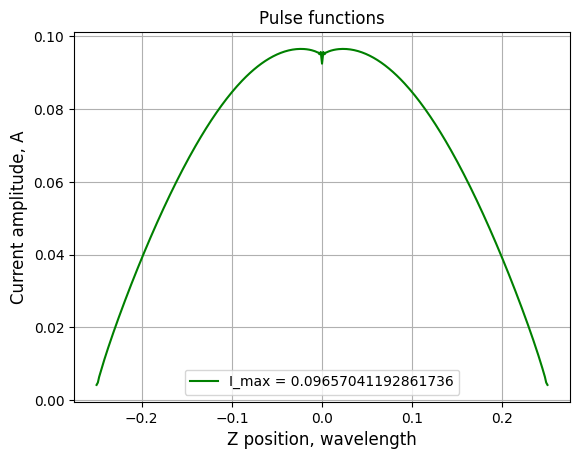

In [36]:
import matplotlib.pyplot as plt 
plt.plot(R_pulse[:,2]/wavelength, np.abs(current_pulse), color = 'green', label = f'I_max = {np.max(np.abs(current_pulse))}')
plt.xlabel('Z position, wavelength', size = 12)
plt.ylabel('Current amplitude, A', size = 12)
plt.title('Pulse functions')
plt.grid()
plt.legend()

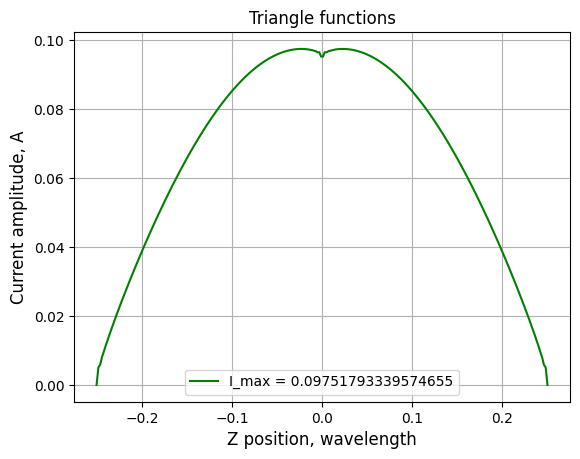

In [39]:
import matplotlib.pyplot as plt 
plt.plot(R_triangle[:,2]/wavelength, np.abs(current_triangle), color = 'green', label = f'I_max = {np.max(np.abs(current_triangle))}')
plt.xlabel('Z position, wavelength', size = 12)
plt.ylabel('Current amplitude, A', size = 12)
plt.title('Triangle functions')
plt.grid()
plt.legend()

0.06357391062927523 0.06404990408159748


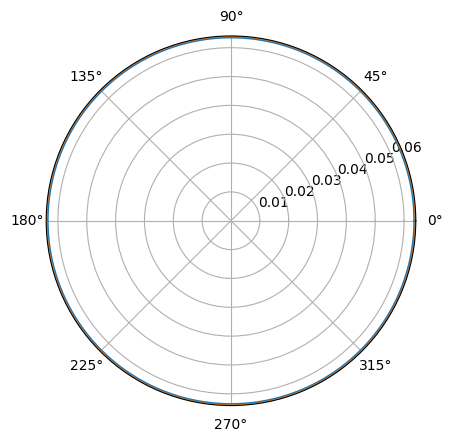

In [ ]:
import matplotlib.pyplot as plt
plt.polar(angles, E_pulse)
plt.polar(angles, E_triangle)
print(np.max(E_pulse), np.max(E_triangle))